In [1]:
import pandas as pd
from qgrid import show_grid
import seaborn as sns
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ranksums
from joblib import Parallel, delayed
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from umap import UMAP
import plotly.express as px

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 4
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.linewidth'] = 0.25

sns.set(style="ticks", context="paper", font_scale=1, font="Arial")
sns.set_context("paper",
                rc={
                    "axes.linewidth": 0.5,
                    'xtick.major.size': 2,
                    'xtick.major.width': 0.25,
                    'ytick.major.size': 2,
                    'ytick.major.width': 0.25,
                    'xtick.labelsize': 6,
                    'ytick.labelsize': 6,
                    'axes.labelsize': 7
                })
metrics = ['acc', 'f1', 'roc_auc']
model_palette = {
    'DeepPathNet': '#4c72b0',
    'random forest': '#dd8452',
    'PCA': '#c44e52',
    'moCluster': '#8172b3',
    'mixOmics': '#937860',
    'decision tree':'#da8bc3',
    'KNN':'#8c8c8c'
}

In [3]:
omics_colour = {
    'mutation': 'grey',
    'cnv': 'orange',
    'methy': 'limegreen',
    'rna': 'skyblue'
}
tissue_colours = {
    'Lung': '#007fff',
    'Prostate': '#665d1e',
    'Stomach': '#ffbf00',
    'Central Nervous System': '#fbceb1',
    'Skin': '#ff033e',
    'Bladder': '#ab274f',
    'Haematopoietic and Lymphoid': '#d5e6f7',
    'Kidney': '#7cb9e8',
    'Thyroid': '#efdecd',
    'Soft Tissue': '#8db600',
    'Head and Neck': '#e9d66b',
    'Ovary': '#b284be',
    'Bone': '#b2beb5',
    'Endometrium': '#10b36f',
    'Breast': '#6e7f80',
    'Pancreas': '#ff7e00',
    'Peripheral Nervous System': '#87a96b',
    'Cervix': '#c9ffe5',
    'Large Intestine': '#9f2b68',
    'Liver': '#00ffff',
    'Vulva': '#008000',
    'Esophagus': '#cd9575',
    'Biliary Tract': '#72a0c1',
    'Other tissue': '#a32638',
    'Small Intestine': '#9966cc',
    'Placenta': '#f19cbb',
    'Testis': '#e32636',
    'Adrenal Gland': '#3b7a57',
    'Uterus': '#faebd7'
}
cancer_colours = {
    'Non-Small Cell Lung Carcinoma': '#007fff',
    'Prostate Carcinoma': '#665d1e',
    'Gastric Carcinoma': '#ffbf00',
    'Glioblastoma': '#fbceb1',
    'Melanoma': '#ff033e',
    'Bladder Carcinoma': '#ab274f',
    'B-Lymphoblastic Leukemia': '#d5e6f7',
    'Kidney Carcinoma': '#7cb9e8',
    'Thyroid Gland Carcinoma': '#efdecd',
    'Rhabdomyosarcoma': '#8db600',
    'Head and Neck Carcinoma': '#e9d66b',
    'Ovarian Carcinoma': '#b284be',
    "B-Cell Non-Hodgkin's Lymphoma": '#b2beb5',
    'Other Solid Carcinomas': '#10b36f',
    "Ewing's Sarcoma": '#6e7f80',
    'T-Lymphoblastic Leukemia': '#ff7e00',
    'Plasma Cell Myeloma': '#87a96b',
    'Endometrial Carcinoma': '#c9ffe5',
    'Non-Cancerous': '#9f2b68',
    'Breast Carcinoma': '#00ffff',
    'Pancreatic Carcinoma': '#008000',
    'Neuroblastoma': '#cd9575',
    "Burkitt's Lymphoma": '#72a0c1',
    'Hairy Cell Leukemia': '#a32638',
    'Chronic Myelogenous Leukemia': '#9966cc',
    'Glioma': '#f19cbb',
    'Cervical Carcinoma': '#e32636',
    'Colorectal Carcinoma': '#3b7a57',
    'Hepatocellular Carcinoma': '#faebd7',
    'Vulvar carcinoma': '#fdee00',
    'Osteosarcoma': '#00308f',
    'Chondrosarcoma': '#7fffd4',
    'Small Cell Lung Carcinoma': '#c46210',
    'Esophageal Carcinoma': '#a8bb19',
    'Uncertain': '#ff9966',
    "T-Cell Non-Hodgkin's Lymphoma": '#a52a2a',
    'Non-small Cell Lung Carcinoma': '#568203',
#     'Other Sarcomas': '#4b5320',
    'Biliary Tract Carcinoma': '#5d8aa8',
    'Acute Myeloid Leukemia': '#8f9779',
    "Hodgkin's Lymphoma": '#915c83',
    'Mesothelioma': '#841b2d',
    'B-Lymphoblastic leukemia': '#a4c639',
    'Other Blood Cancers': '#3b444b',
    'Carcinoid Tumour': '#006600',
    'Leiomyosarcoma': '#0000ff',
    "T-cell Non-Hodgkin's Lymphoma": '#666699',
    'Other Blood Carcinomas':'#996666', 
    'Esophageal Squamous Cell Carcinoma':'#990000', 
    'Squamous Cell Lung Carcinoma':'#cc0000', 
    'Oral Cavity Carcinoma':'#4b5320'
}


In [4]:
drug_df = pd.read_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide_cov.csv.gz",
    index_col=0)
cell_meta = pd.read_excel("../data/meta/SamplesheetApril2020.xlsx").rename(columns={'model_name':'Cell_line'})
omics_data_df = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_tissue_drug.csv.gz",
    index_col=0)

In [5]:
def plot_scatter(df_a, df_b, cell_meta, x='', y=''):
    tmp_df = pd.merge(df_a, df_b, on='Cell_line')
    tmp_df = pd.merge(tmp_df, cell_meta, on='Cell_line')
    fig = px.scatter(tmp_df,
               x=x,
               y=y,
               color='tissue',
#                palette=tissue_colours,
               hover_data=['tissue'])
    fig.show()

# Drug

## LC

In [5]:
omics_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/lc_pathway_min50_202105071210/shapgrad_genes_202105071210.csv.gz"
)
omics_df = omics_df[omics_df['sum']>0]

tissue_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/lc_pathway_min50_202105071210/shapgrad_tissue_202105071210.csv.gz"
)

pathway_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/lc_pathway_min50_202105071210/explanation_202105071210.csv.gz"
)


tissue_df['tissue'] = tissue_df['tissue'].map(lambda x:x.replace('tissue_',''))

omics_df_stack = omics_df.copy()

omics_df_stack['cnv'] = omics_df_stack['mutation'] + omics_df_stack['cnv']

omics_df_stack['methy'] = omics_df_stack['cnv'] + omics_df_stack['methy']
omics_df_stack['rna'] = omics_df_stack['methy'] + omics_df_stack['rna']



### Dabrafenib

In [63]:
drug_id = '1373;Dabrafenib;GDSC2'

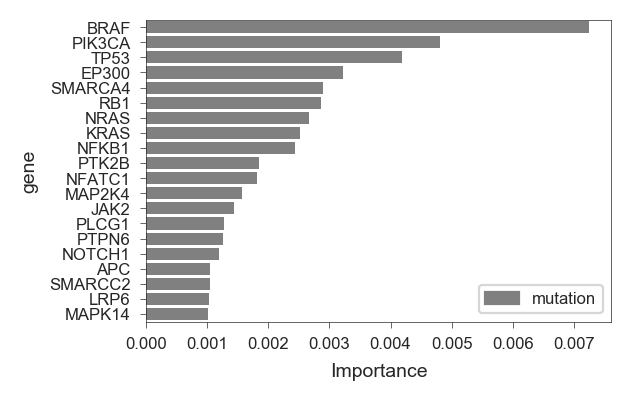

In [29]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')
plt.savefig("../plots/dabrafenib_mutation.pdf",dpi=500)

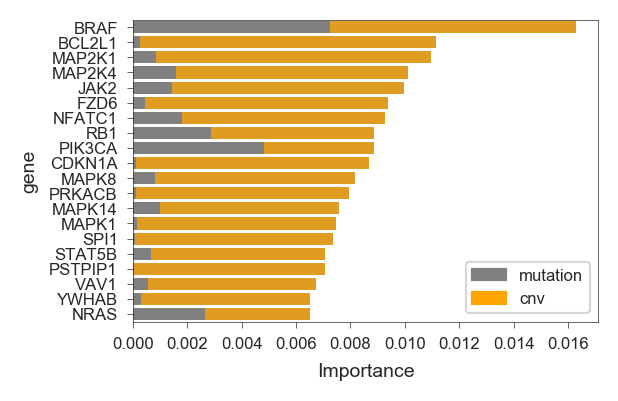

In [30]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')
plt.savefig("../plots/dabrafenib_mutation_cnv.pdf",dpi=500)

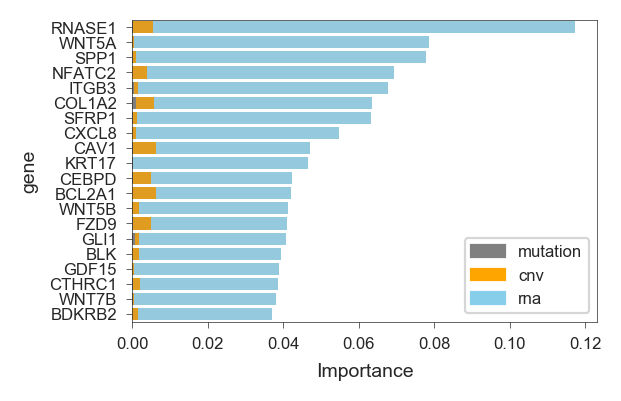

In [31]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','cnv','mutation'], sorting='rna')
plt.savefig("../plots/dabrafenib_mutation_cnv_rna.pdf",dpi=500)

In [24]:
plot_scatter(omics_data_df, drug_df, cell_meta, x='SPP1_rna', y=drug_id)

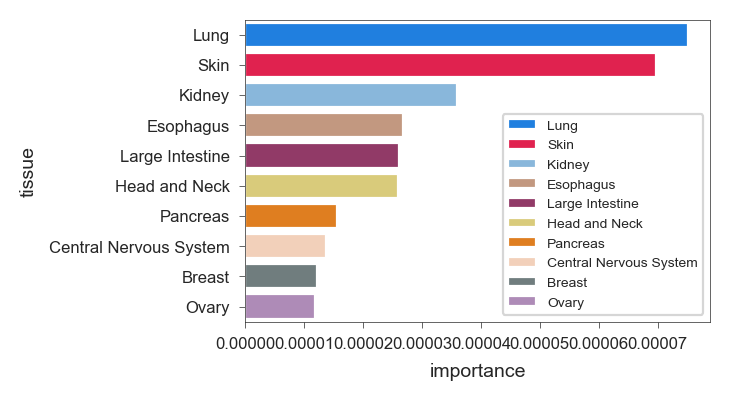

In [64]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)
plt.legend(prop={'size': 5})
plt.savefig("../plots/dabrafenib_tissue.pdf",dpi=500)

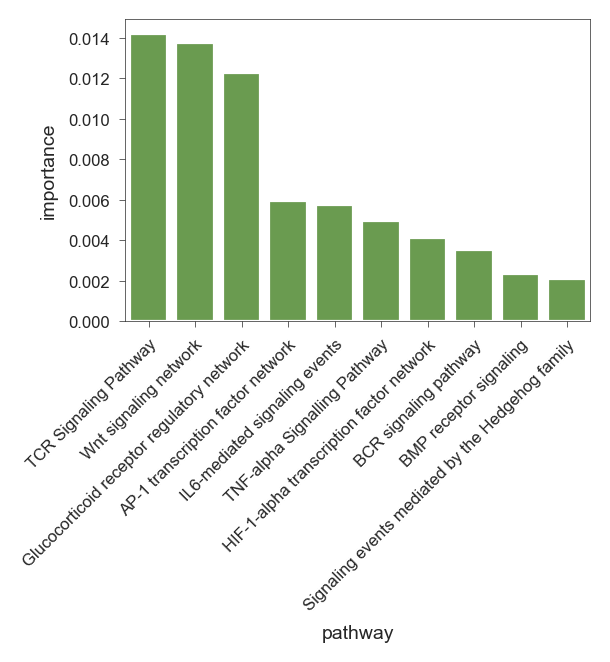

In [55]:
sns.barplot(x='pathway',
            y='importance',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='#66A744')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig("../plots/dabrafenib_pathway.pdf",dpi=500)

### Venetoclax

In [65]:
drug_id = '1909;Venetoclax;GDSC2'

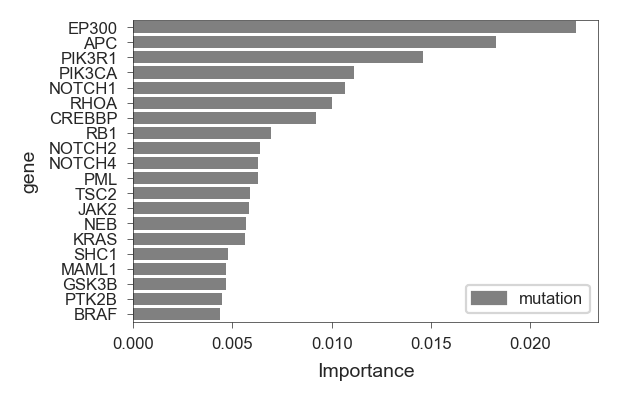

In [52]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')
plt.savefig("../plots/venetoclax_mutation.pdf",dpi=500)

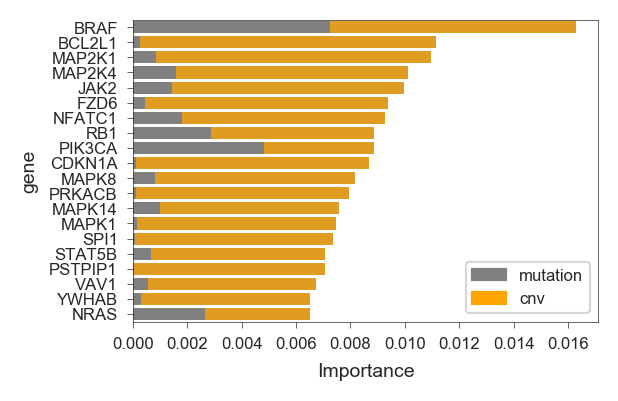

In [34]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')
plt.savefig("../plots/venetoclax_mutation_cnv.pdf",dpi=500)

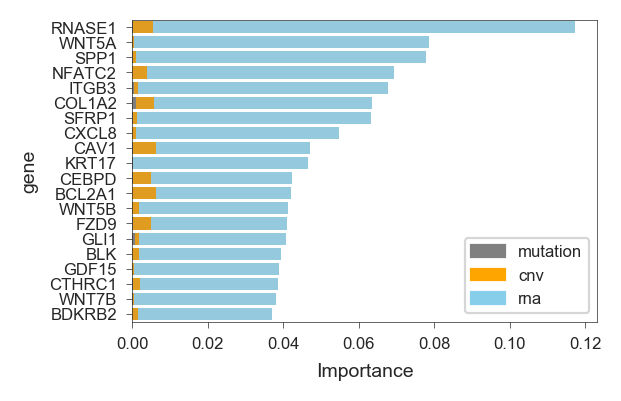

In [35]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','cnv','mutation'], sorting='rna')
plt.savefig("../plots/venetoclax_mutation_cnv_rna.pdf",dpi=500)

In [ ]:
plot_scatter(omics_data_df, drug_df, cell_meta, x='SPP1_rna', y=drug_id)

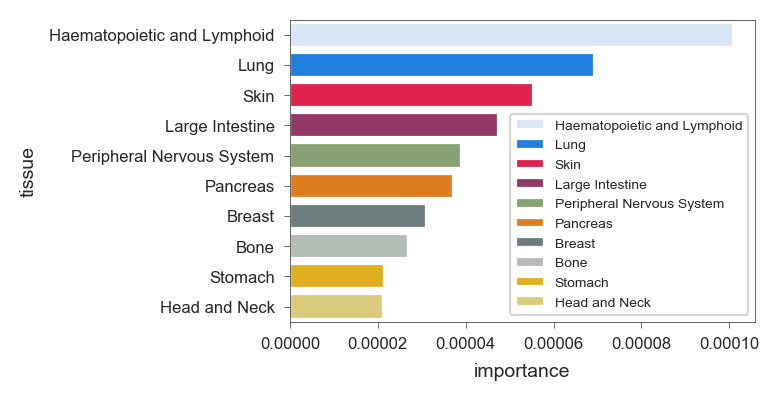

In [66]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)
plt.legend(prop={'size': 5})
plt.savefig("../plots/venetoclax_tissue.pdf",dpi=500)

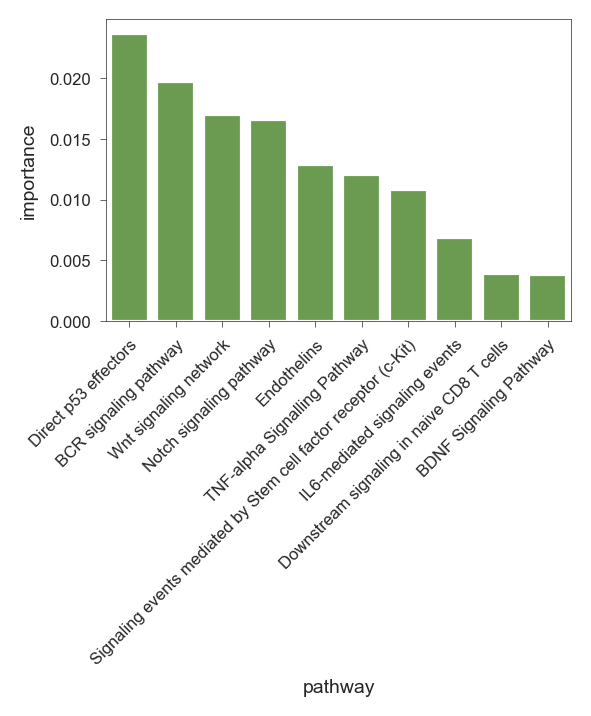

In [57]:
sns.barplot(x='pathway',
            y='importance',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='#66A744')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig("../plots/venetoclax_pathway.pdf",dpi=500)

### Afatinib

In [67]:
drug_id = '1032;Afatinib;GDSC2'

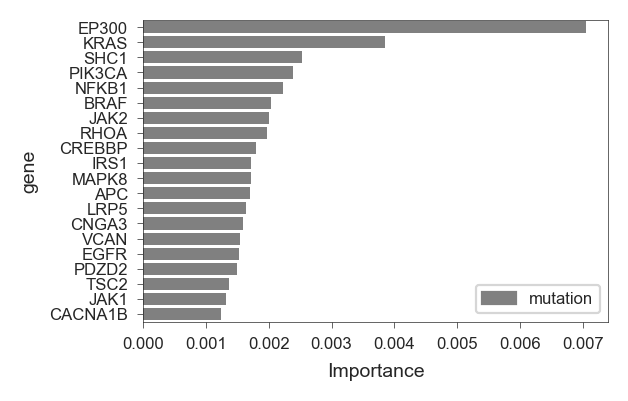

In [44]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')
plt.savefig("../plots/afatinib_mutation.pdf",dpi=500)

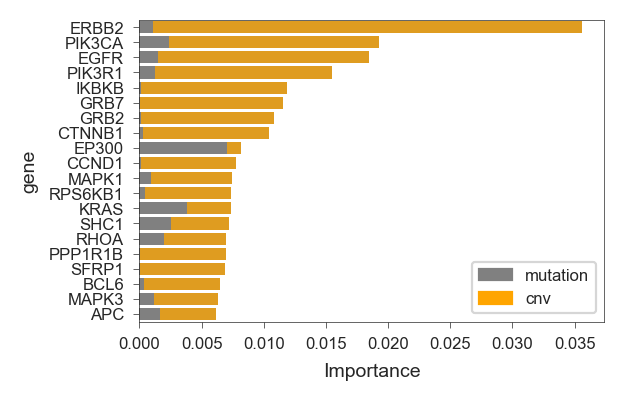

In [45]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')
plt.savefig("../plots/afatinib_mutation_cnv.pdf",dpi=500)

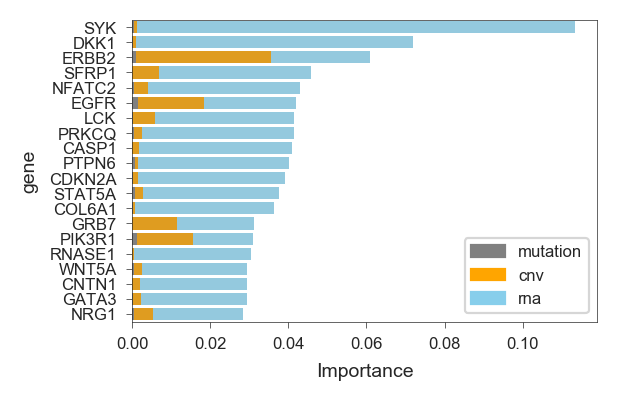

In [47]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','cnv','mutation'], sorting='rna')
plt.savefig("../plots/afatinib_mutation_cnv_rna.pdf",dpi=500)

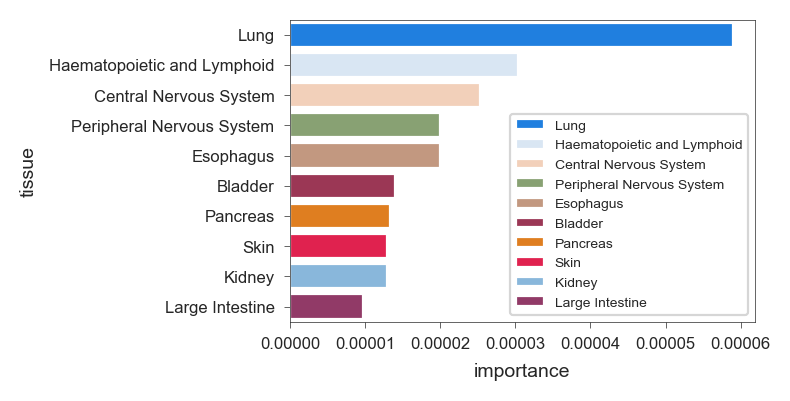

In [68]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)
plt.legend(prop={'size': 5})
plt.savefig("../plots/afatinib_tissue.pdf",dpi=500)

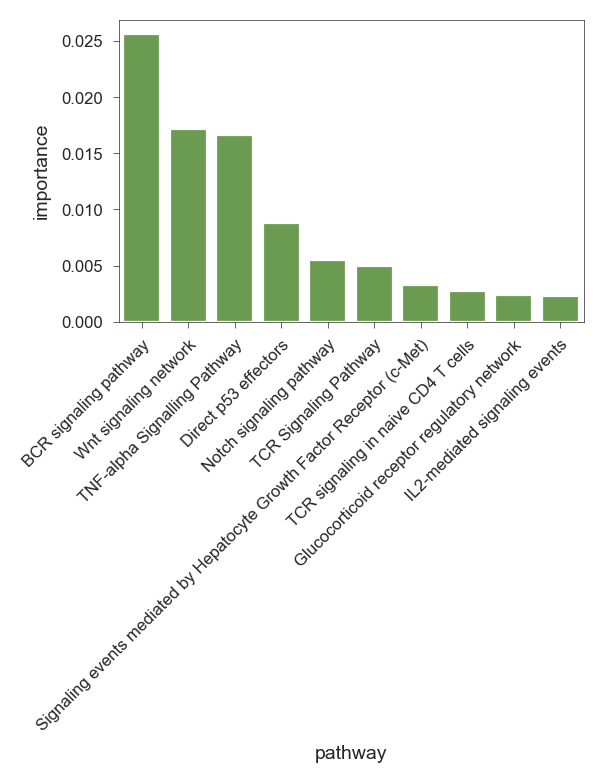

In [59]:
sns.barplot(x='pathway',
            y='importance',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='#66A744')
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.savefig("../plots/afatinib_pathway.pdf",dpi=500)

## REACTOME

In [31]:

omics_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/reactome_10pathways_202106101715/shapgrad_genes_202106101715.csv.gz"
)
omics_df = omics_df[omics_df['sum']>0]

tissue_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/reactome_10pathways_202106101715/shapgrad_tissue_202106101715.csv.gz"
)

pathway_df = pd.read_csv(
    "../work_dirs/sanger_gdsc_intersection_noprot_tissue_cov/DeepMultiOmicNet/mutation_cnv_methy_rna/single_mode/reactome_10pathways_202106101715/explanation_202106101715.csv.gz"
)


tissue_df['tissue'] = tissue_df['tissue'].map(lambda x:x.replace('tissue_',''))

omics_df_stack = omics_df.copy()

omics_df_stack['cnv'] = omics_df_stack['mutation'] + omics_df_stack['cnv']

omics_df_stack['methy'] = omics_df_stack['cnv'] + omics_df_stack['methy']
omics_df_stack['rna'] = omics_df_stack['methy'] + omics_df_stack['rna']



In [9]:
def plot_omics_stack(omics_df,
                     target,
                     target_col='drug_id',
                     omics=['rna', 'methy', 'cnv', 'mutation'],
                     sorting='rna'):
    legends = []
    for omic in omics:
        sns.barplot(y=omic,
                    x='gene',
                    data=omics_df[omics_df[target_col] == target].sort_values(
                        by=sorting, ascending=False).head(20),
                    color=omics_colour[omic])
        legends.append(mpatches.Patch(color=omics_colour[omic], label=omic))
    plt.xlabel('Importance')
    legends.reverse()
    plt.legend(handles=legends)

In [33]:
def plot_scatter(df_a, df_b, cell_meta, x='', y=''):
    tmp_df = pd.merge(df_a, df_b, on='Cell_line')
    tmp_df = pd.merge(tmp_df, cell_meta, on='Cell_line')
    fig = px.scatter(tmp_df,
               x=x,
               y=y,
               color='tissue',
#                palette=tissue_colours,
               hover_data=['tissue'])
    fig.show()

### Dabrafenib

In [34]:
drug_id = '1373;Dabrafenib;GDSC2'

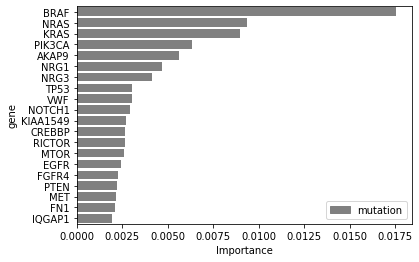

In [35]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')

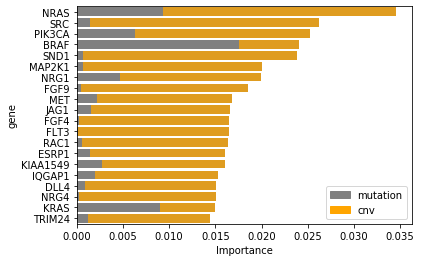

In [36]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')

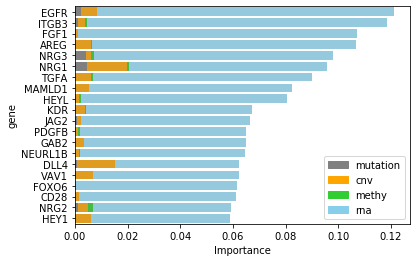

In [37]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','methy','cnv','mutation'], sorting='rna')

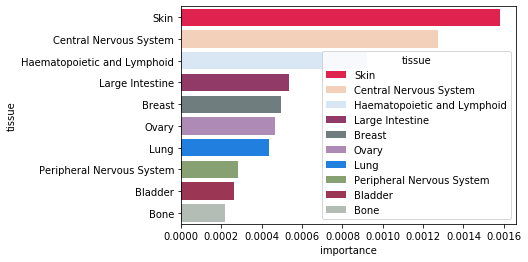

In [39]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)

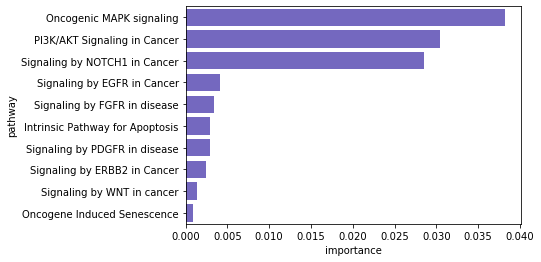

In [40]:
sns.barplot(x='importance',
            y='pathway',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='slateblue')

### Venetoclax

In [41]:
drug_id = '1909;Venetoclax;GDSC2'

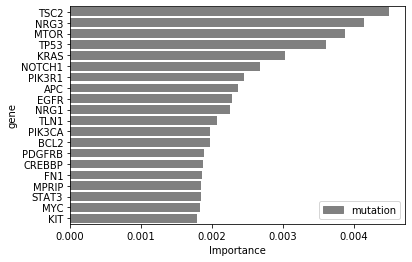

In [42]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')

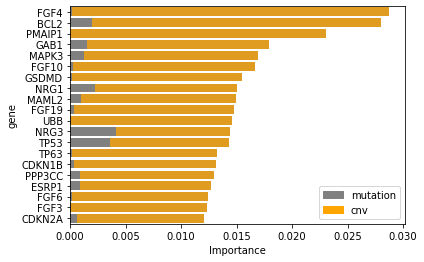

In [43]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')

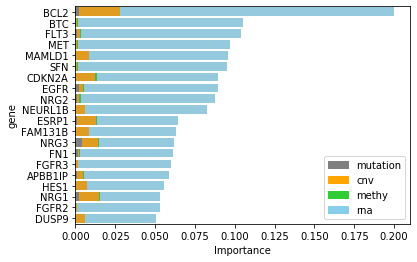

In [44]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','methy','cnv','mutation'], sorting='rna')

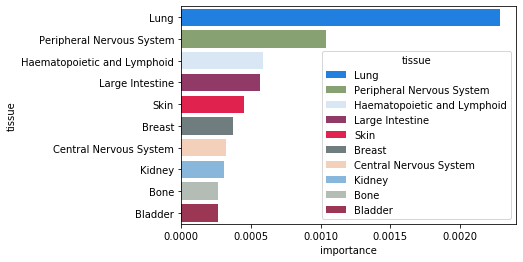

In [45]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)

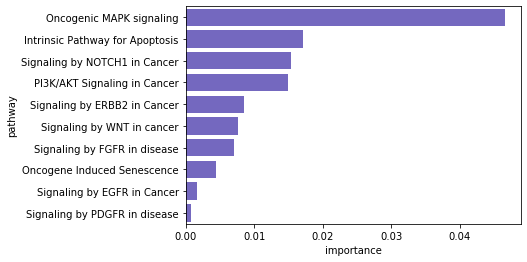

In [46]:
sns.barplot(x='importance',
            y='pathway',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='slateblue')

### Afatinib

In [47]:
drug_id = '1032;Afatinib;GDSC2'

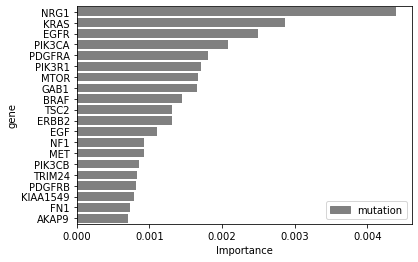

In [48]:
plot_omics_stack(omics_df_stack, drug_id, omics=['mutation'], sorting='mutation')

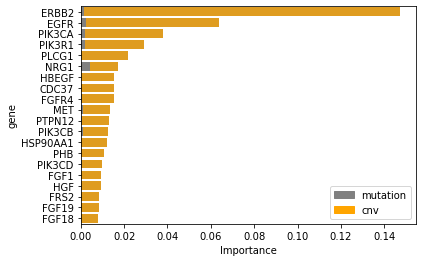

In [49]:
plot_omics_stack(omics_df_stack, drug_id, omics=['cnv','mutation'], sorting='cnv')

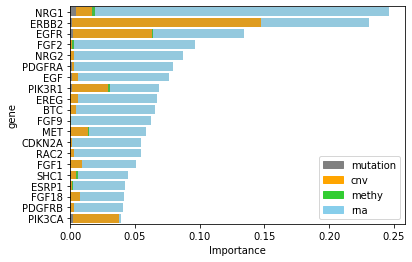

In [50]:
plot_omics_stack(omics_df_stack, drug_id, omics=['rna','methy','cnv','mutation'], sorting='rna')

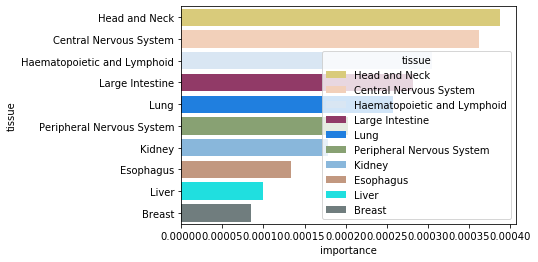

In [51]:
sns.barplot(x='importance',
            y='tissue',
            data=tissue_df[tissue_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            hue='tissue', dodge=False,
            palette=tissue_colours)

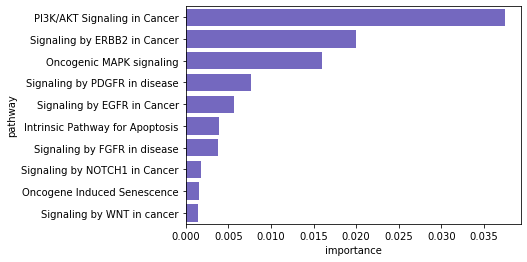

In [52]:
sns.barplot(x='importance',
            y='pathway',
            data=pathway_df[pathway_df['drug_id'] == drug_id].sort_values(
                by='importance', ascending=False).head(10),
            color='slateblue')

# cancer type

## LRP min 50

In [15]:
def plot_omics_stack(omics_df,
                     target,
                     target_col='drug_id',
                     omics=['rna', 'methy', 'cnv', 'mutation'],
                     sorting='rna',
                     n=5):
    legends = []
    for omic in omics:
        sns.barplot(y=omic,
                    x='gene',
                    data=omics_df[omics_df[target_col] == target].sort_values(
                        by=sorting, ascending=False).head(n),
                    color=omics_colour[omic],
                    linewidth=0)
        legends.append(mpatches.Patch(color=omics_colour[omic], label=omic))
    plt.ylabel('Importance')
    legends.reverse()


#     plt.legend(handles=legends, prop={'size': 6})

In [7]:
omics_df = pd.read_csv(
    "../work_dirs/tcga_brca_subtypes/DeepMultiOmicNet/mutation_cnv_rna/shapgrad_genes_202202081127_Cancer_type.csv.gz"
)
omics_df = omics_df[omics_df['sum']>0]


pathway_df = pd.read_csv(
    "../work_dirs/tcga_brca_subtypes/DeepMultiOmicNet/mutation_cnv_rna/explanation_202202081127_Cancer_type.csv"
)

omics_df_stack = omics_df.copy()
omics_df_stack['cnv'] = omics_df_stack['mutation'] + omics_df_stack['cnv']
omics_df_stack['rna'] = omics_df_stack['cnv'] + omics_df_stack['rna']

In [8]:
show_grid(omics_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

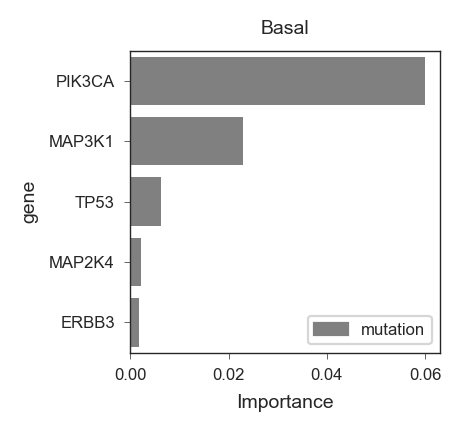

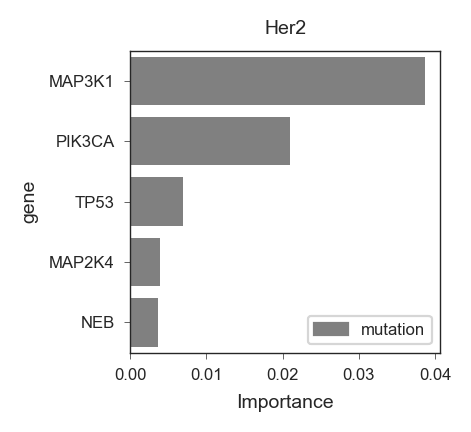

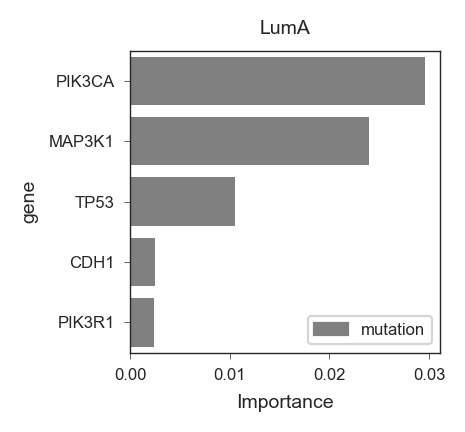

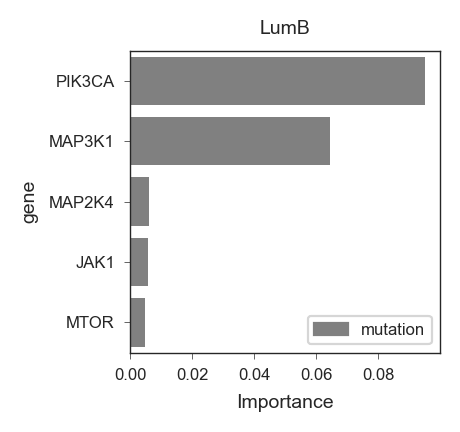

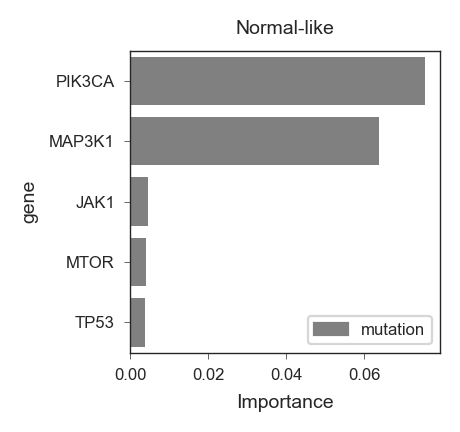

In [10]:
for cancer_type in omics_df['cancer_type'].unique():
    plt.figure(figsize=(2, 2))
    plot_omics_stack(omics_df_stack,
                     cancer_type,
                     'cancer_type',
                     omics=['mutation'],
                     sorting='mutation')
    plt.title(cancer_type, fontdict={'size': 7})
    plt.savefig(f"../plots/explanation/brca_{cancer_type}_mutation.pdf", dpi=300)

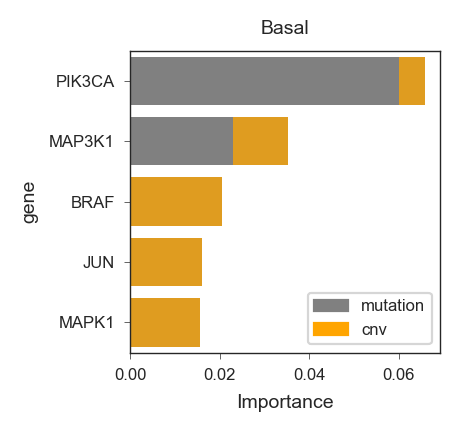

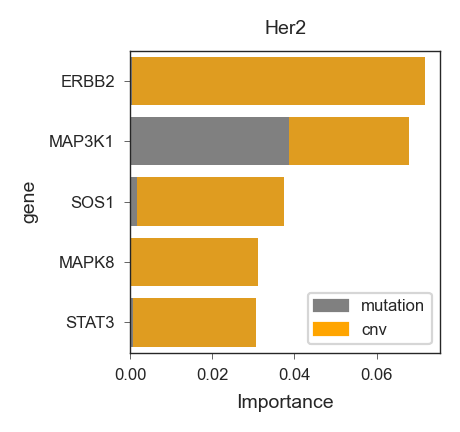

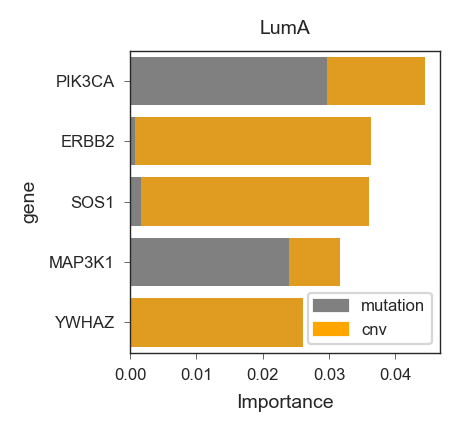

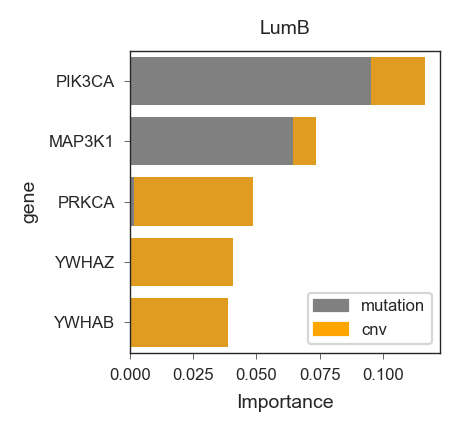

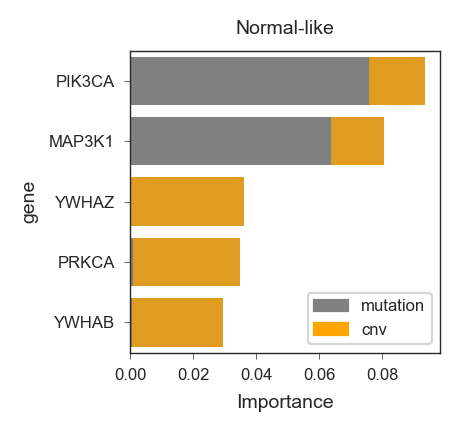

In [11]:
for cancer_type in omics_df['cancer_type'].unique():
    plt.figure(figsize=(2, 2))
    plot_omics_stack(omics_df_stack,
                     cancer_type,
                     'cancer_type',
                     omics=['cnv', 'mutation'],
                     sorting='cnv')
    plt.title(cancer_type, fontdict={'size': 7})
    plt.savefig(f"../plots/explanation/brca_{cancer_type}_mutation_cnv.pdf", dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


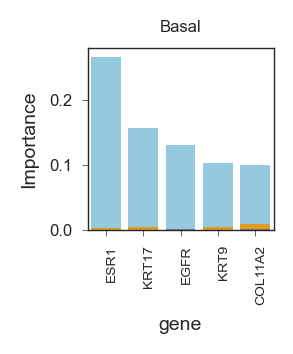

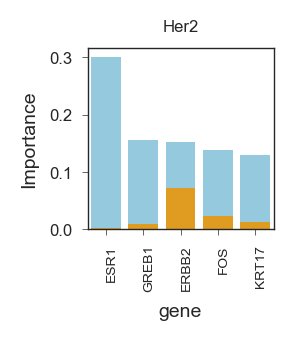

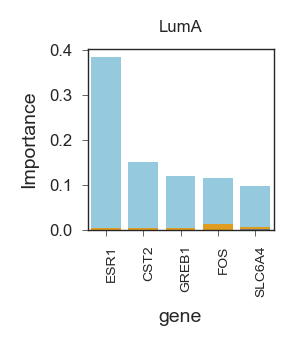

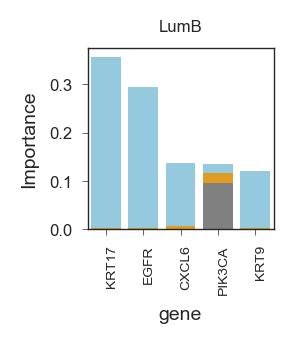

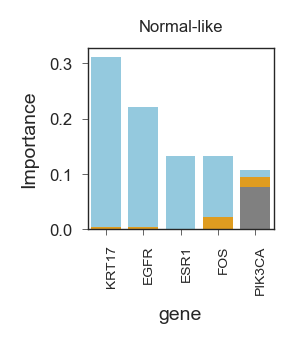

In [16]:
for cancer_type in omics_df['cancer_type'].unique():
    plt.figure(figsize=(1.2, 1.2))
    plot_omics_stack(omics_df_stack,
                     cancer_type,
                     'cancer_type',
                     omics=['rna', 'cnv', 'mutation'],
                     sorting='rna')
    plt.title(cancer_type, fontdict={'size': 6})
    plt.xticks(rotation=90, ha='right', rotation_mode="anchor", size=5)
    plt.legend().remove()
    plt.savefig(f"../plots/explanation/brca_{cancer_type}_mutation_cnv_rna.pdf", dpi=300)

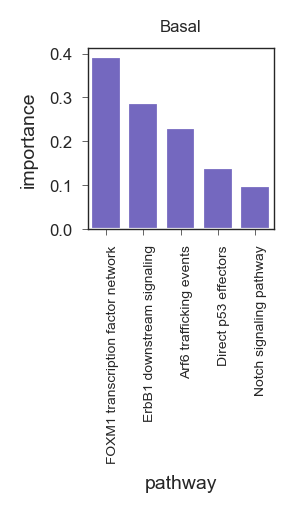

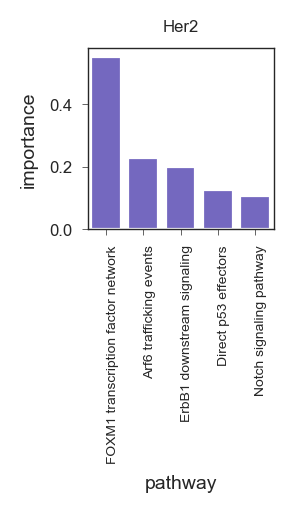

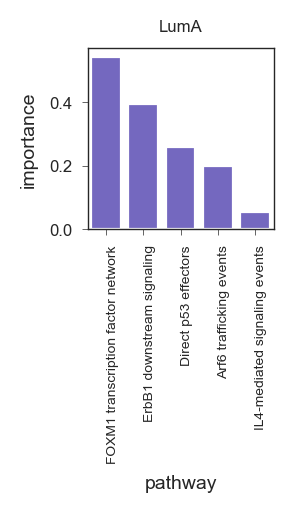

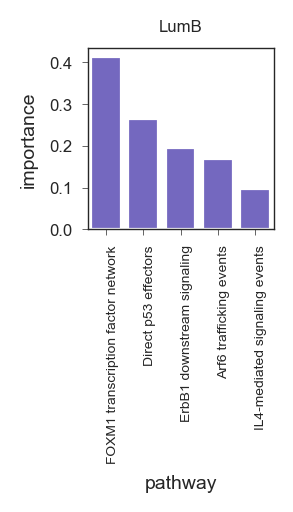

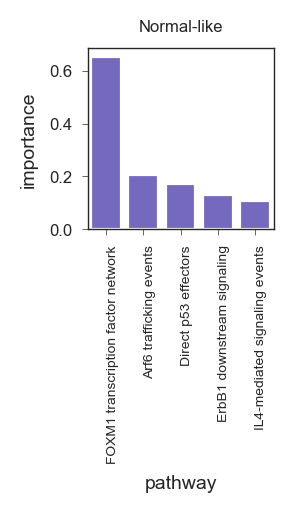

In [20]:
for cancer_type in omics_df['cancer_type'].unique():
    plt.figure(figsize=(1.2, 1.2))
    sns.barplot(
        x='pathway',
        y='importance',
        data=pathway_df[pathway_df['cancer_type'] == cancer_type].sort_values(
            by='importance', ascending=False).head(5),
        color='slateblue')
    plt.xticks(rotation=90, ha='right', rotation_mode="anchor", size=5)

    plt.title(cancer_type, fontdict={'size': 6})
    plt.savefig(f"../plots/explanation/brca_{cancer_type}_pathway.pdf",
                dpi=300)

## Reactome 10

In [13]:
omics_df = pd.read_csv(
    "../work_dirs/sanger_cancer_type_intersection_noprot/DeepMultiOmicNet/mutation_cnv_methy_rna/shapgrad_genes_202106101656_Cancer_type.csv.gz"
)
omics_df = omics_df[omics_df['sum']>0]


pathway_df = pd.read_csv(
    "../work_dirs/sanger_cancer_type_intersection_noprot/DeepMultiOmicNet/mutation_cnv_methy_rna/explanation_202106101656_Cancer_type.csv"
)

omics_df_stack = omics_df.copy()
omics_df_stack['cnv'] = omics_df_stack['mutation'] + omics_df_stack['cnv']
omics_df_stack['methy'] = omics_df_stack['cnv'] + omics_df_stack['methy']
omics_df_stack['rna'] = omics_df_stack['methy'] + omics_df_stack['rna']

In [14]:
show_grid(omics_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

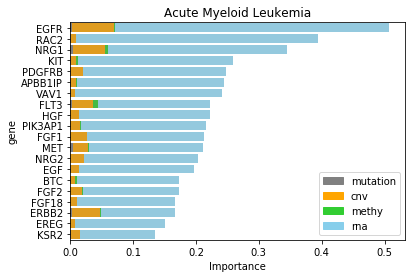

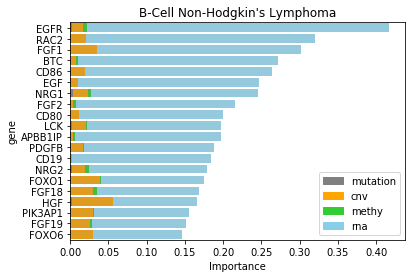

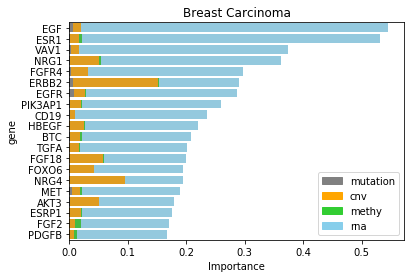

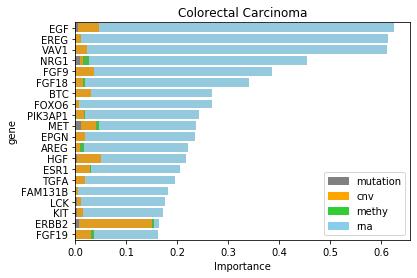

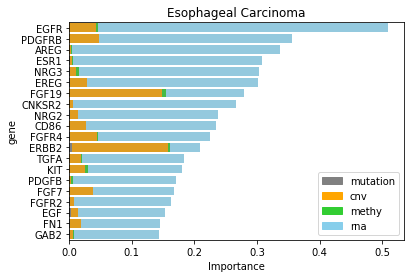

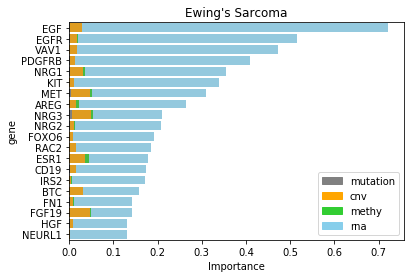

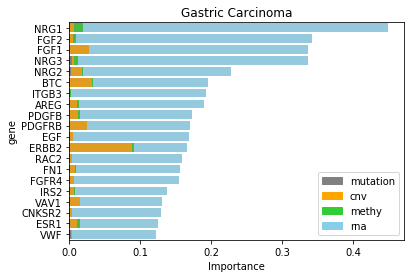

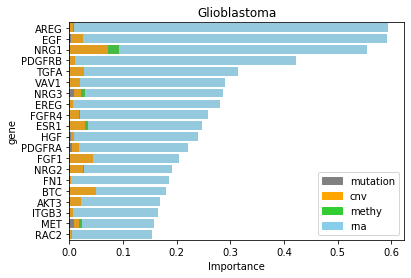

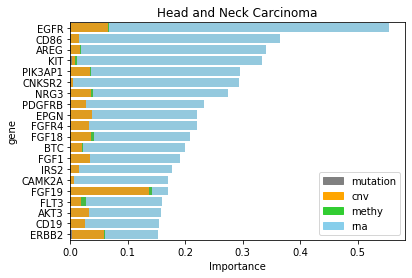

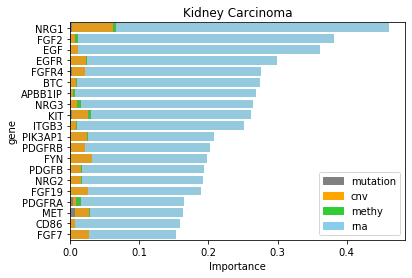

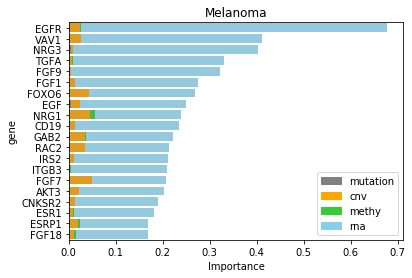

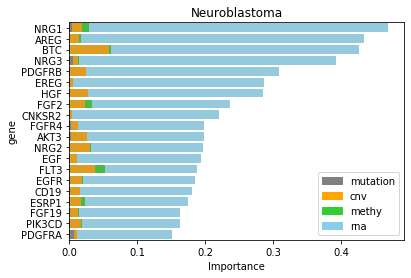

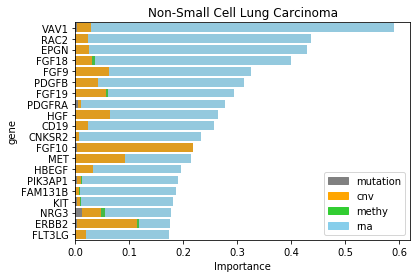

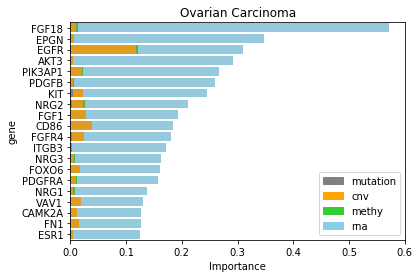

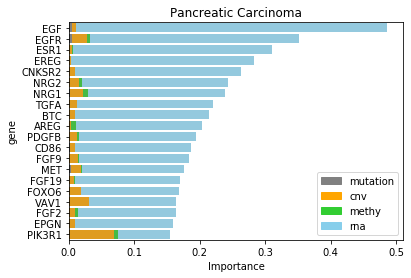

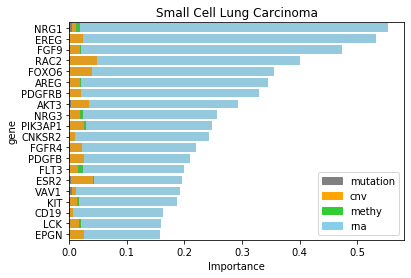

In [18]:
for cancer_type in omics_df['cancer_type'].unique():
    plot_omics_stack(omics_df_stack,
                     cancer_type,
                     'cancer_type',
                     omics=['rna', 'methy', 'cnv', 'mutation'],
                     sorting='rna')
    plt.title(cancer_type)
    plt.show()

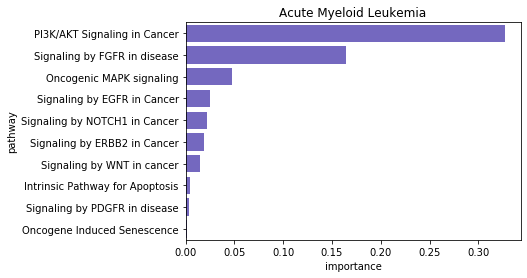

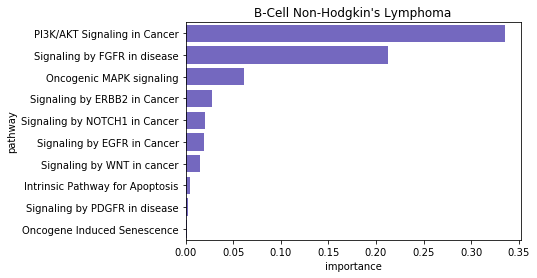

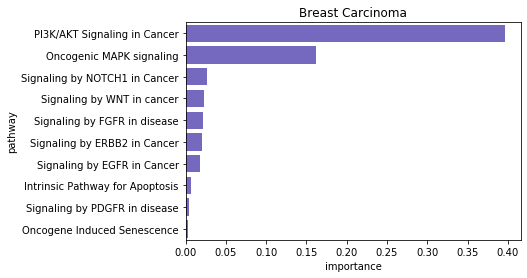

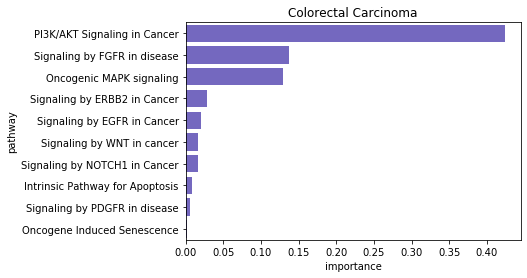

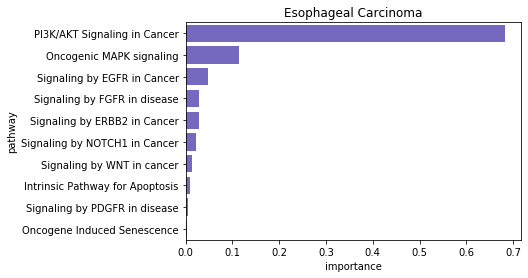

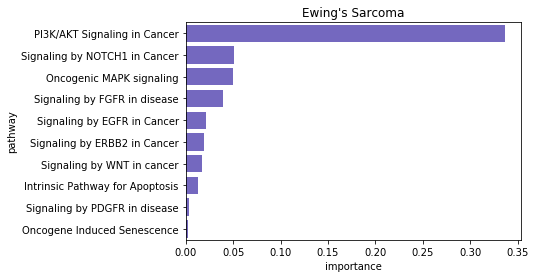

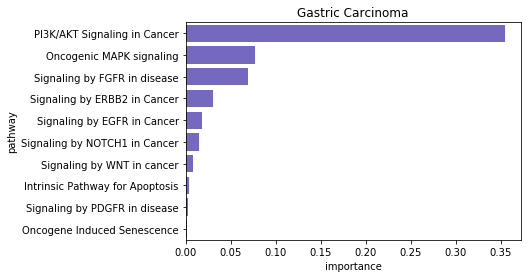

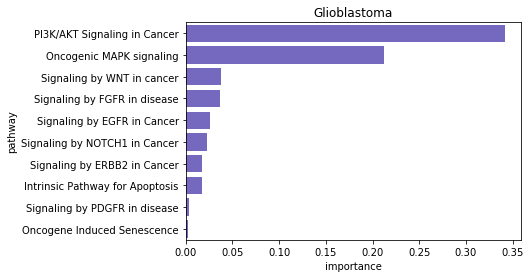

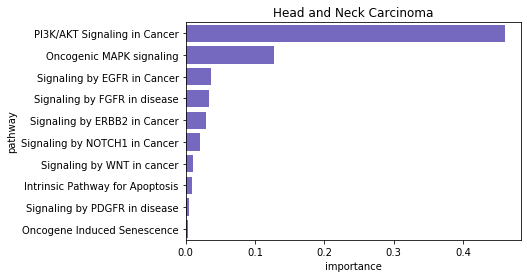

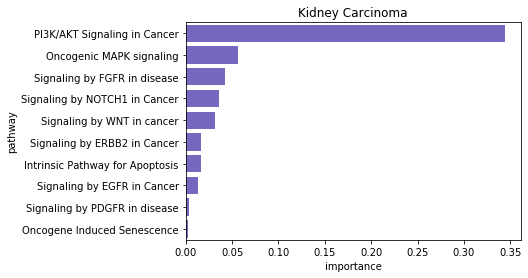

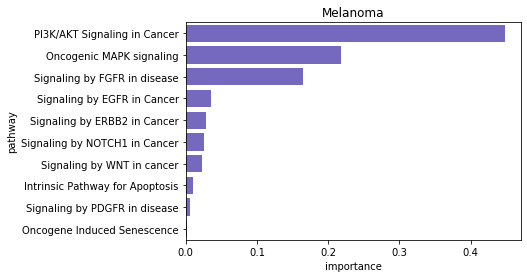

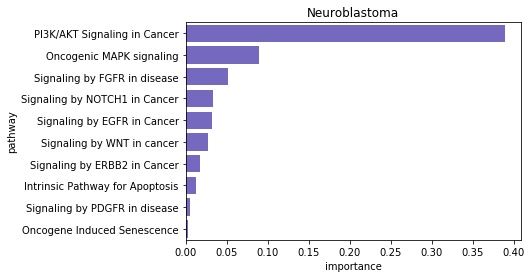

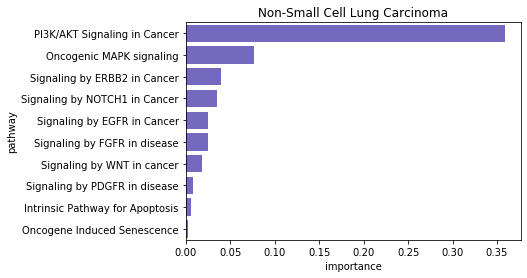

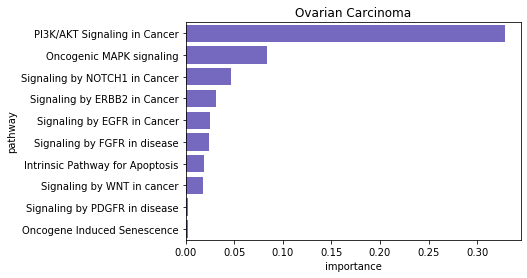

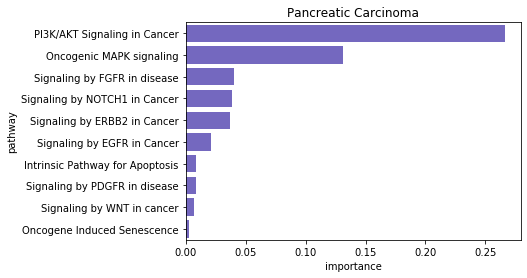

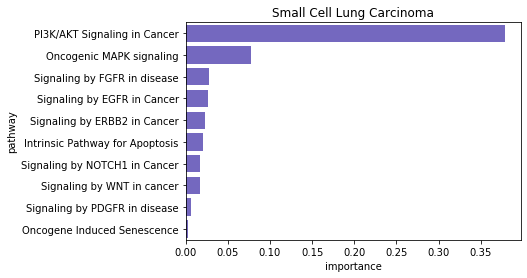

In [19]:
for cancer_type in omics_df['cancer_type'].unique():
    sns.barplot(x='importance',
            y='pathway',
            data=pathway_df[pathway_df['cancer_type'] == cancer_type].sort_values(
                by='importance', ascending=False).head(10), color='slateblue')
    plt.title(cancer_type)
    plt.show()